In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time as t
import random as r
from tqdm import tqdm

In [64]:
trainCsv = pd.read_csv('cardiac.csv')

In [65]:
trainCsv

,ID,RRmean,PTdis,STdis,RRTot,SDRR,hbpermin,PQdis,PQslope,QRdis,QRSseg,PQseg,Pseg,NN50,STseg,STslope,Tseg
0,0,358.185185,95.000002,36.375684,28,118.947245,60.179104,24.164337,-0.039751,16.971024,0.095734,0.068552,0.029563,11,0.101091,0.017092,0.108631
1,1,84.134454,20.786934,13.809141,120,3.059424,91.428571,7.078599,-0.193178,0.050422,0.021151,0.063310,0.050924,1,0.100705,0.063261,0.089558
2,2,315.258064,89.258170,21.690140,32,11.503065,68.571429,29.003153,-0.013569,22.501573,0.101389,0.084500,0.064722,4,0.068889,0.034507,0.094667
3,3,197.693878,38.413132,25.029068,50,1.798004,75.000000,13.531768,-0.136163,0.000000,0.000000,0.053095,0.064714,0,0.100000,0.048226,0.100190
4,4,312.838710,105.806455,35.747960,32,11.273997,68.503469,38.327021,-0.015234,16.125269,0.088108,0.106771,0.043837,2,0.099306,0.018280,0.095399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,297.375000,96.781787,36.783138,33,63.553496,71.280000,25.607664,-0.032664,18.349942,0.093697,0.087447,0.070246,7,0.100267,0.009748,0.129167
896,896,286.882353,67.382815,21.654941,35,24.585702,75.000000,15.535835,-0.067423,14.895967,0.068750,0.059989,0.047756,4,0.074466,0.027122,0.102938
897,897,108.163044,30.521773,6.680616,93,9.026865,71.139442,12.971889,-0.048678,5.739907,0.072980,0.092511,0.058975,7,0.069264,0.136371,0.061452
898,898,146.328358,39.435649,25.710653,68,7.213975,102.000000,13.453077,-0.086668,0.149677,0.013432,0.060741,0.060494,1,0.098173,0.026701,0.156494


In [66]:
X = trainCsv.to_numpy()

In [67]:
ids, X = X[:, 0], X[:, 1:]

ids = ids.astype(int)

In [68]:
class KMeansClustering:
    def __init__(self, points, centroidAmount):
        self.points = points
        self.centroidAmount = centroidAmount
        self.createCentroids()
        
    def createCentroids(self):
        self.centroids = np.empty((0, self.points.shape[1]))
        for _ in range(self.centroidAmount):
            centroid = []
            for colIdx in range(self.points.shape[1]):
                col = self.points[:, colIdx]
                centroid.append(np.random.randint(int(col.min()), int(col.max())+1))
            self.centroids = np.vstack((self.centroids, tuple(centroid)))


    def computeClosestCentroids(self, secondClosest=False):
        dists = np.linalg.norm(
            self.points[:, np.newaxis, :] - self.centroids[np.newaxis, :, :],
            axis=2
        )

        if not secondClosest:
            return np.argmin(dists, 1)
        else:
            partitioned = np.argpartition(dists, 2, axis=1)
            closest = np.argmin(dists, axis=1)

            secondClosest = np.array([
                partitioned[i][1] if partitioned[i][0] == closest[i] else partitioned[i][0]
                for i in range(dists.shape[0])
            ])
            return secondClosest

        
    def fit(self):
        while True:
            closestCentroids = self.computeClosestCentroids()

            oldCentroids = self.centroids.copy()
            for centroid in range(self.centroidAmount):
                assignedPoints = self.points[closestCentroids == centroid]

                if len(assignedPoints) > 0:
                    self.centroids[centroid] = np.mean(assignedPoints, axis=0)
            newCentroids = self.centroids.copy()

            if np.allclose(oldCentroids, newCentroids):
                break

100%|██████████| 20/20 [00:00<00:00, 39.20it/s]

[21.68376118031562, 28.234559564925657, 53.66314530224523, 80.27920067743644, 94.69842272371268, 76.90339219755502, 89.82941278232789, 76.90339219755505, 66.87267497843165, 66.87267497843165, 35.40102917022302, 44.11407558741384, 46.959044384458345, 35.40102917022301, 32.9541128918819, 29.668793628849272, 31.607323208672298, 33.02940683950235, 28.92743777006215, 31.57962499126144]


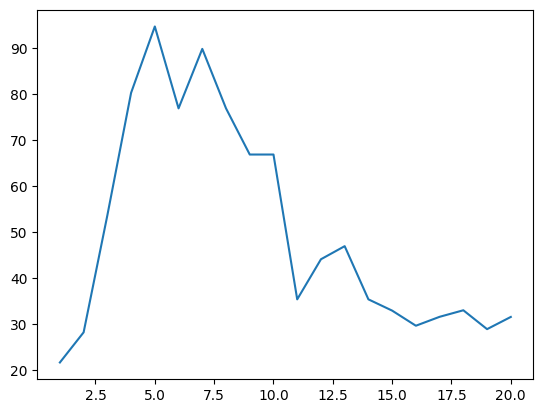

In [69]:
class ElbowMethod:
    def __init__(self, points, kMax):
        self.points = points
        self.kMax = kMax

    def plotGraph(self):
        allKs = list(range(1, self.kMax+1))
        kMSERecords = []
        for k in tqdm(allKs):
            cluster = KMeansClustering(points=self.points, centroidAmount=k)
            cluster.fit()
            clusterClosestCentroids = cluster.computeClosestCentroids()
            # for each point, find the mse and sum
            MSE = 0
            for centroid in range(k):
                matchingPoints = self.points[clusterClosestCentroids == centroid]
                if len(matchingPoints) > 0:
                    MSE += np.mean(np.sum((matchingPoints - cluster.centroids[centroid])**2, axis=1))
            kMSERecords.append(MSE/len(self.points)) # ONLY DIVIDED FOR EASIER INTERPRETABILITY
        print(kMSERecords)
        plt.plot(allKs, kMSERecords)
        plt.show()


elbow = ElbowMethod(points=X, kMax=20)
elbow.plotGraph()

100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


[0.5447324469624312, 0.5456430380162847, 0.5441560404748008, 0.5300361306783826, 0.5412291478865117, 0.454017332625008, 0.5363253434563888, 0.5235856428926224, 0.5235856428926224, 0.5235856428926224, 0.5315855431060545, 0.5194634047916801, 0.4424538695524047, 0.3953468072127458, 0.4449309920087882, 0.44829701427566343, 0.5175707273513885, 0.44195926472225033]


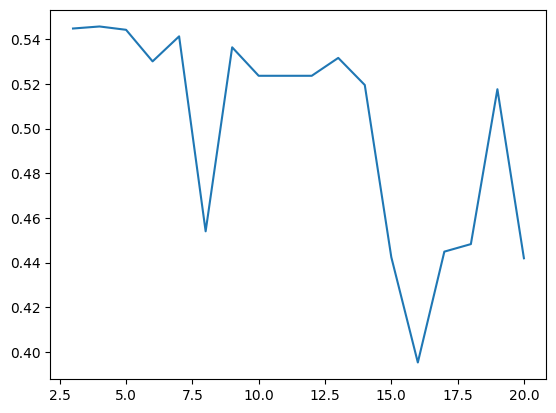

In [70]:
class SilhouetteMethod:
    def __init__(self, points, kMax):
        self.points = points
        self.kMax = kMax


    def silhouetteScore(self, cluster: KMeansClustering):
        closestCentroids = cluster.computeClosestCentroids()
        secondClosestCentroids = cluster.computeClosestCentroids(secondClosest=True)

        globalSilhouetteScore = []

        for i in range(cluster.points.shape[0]):
            point = cluster.points[i]
            closest = closestCentroids[i]
            secondClosest = secondClosestCentroids[i]

            sameClusterPoints = cluster.points[closestCentroids == closest]
            sameClusterPoints = np.delete(sameClusterPoints, np.where(np.all(sameClusterPoints == point, axis=1)), axis=0)

            if sameClusterPoints.shape[0] == 0:
                a = 0 
            else:
                a = np.mean(np.linalg.norm(sameClusterPoints - point, axis=1))

            secondClusterPoints = cluster.points[closestCentroids == secondClosest]
            if secondClusterPoints.shape[0] == 0:
                b = 0
            else:
                b = np.mean(np.linalg.norm(secondClusterPoints - point, axis=1))

            silhouette = (b - a) / max(a, b) if max(a, b) != 0 else 0
            globalSilhouetteScore.append(silhouette)

        return np.mean(globalSilhouetteScore)

    def plotGraph(self):
        allKs = list(range(3, self.kMax+1))
        allScores = []
        for k in tqdm(allKs):
            cluster = KMeansClustering(points=self.points, centroidAmount=k)
            cluster.fit()
            
            allScores.append(self.silhouetteScore(cluster))
        print(allScores)
        plt.plot(allKs, allScores)
        plt.show()

silhouette = SilhouetteMethod(points=X, kMax=20)
silhouette.plotGraph()



In [71]:

import csv

testCluster = KMeansClustering(points=X, centroidAmount=50)
testCluster.fit()

with open('cardiacPredictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Category'])
    for index, pred in zip(ids, testCluster.computeClosestCentroids()):
        writer.writerow([int(index), pred])
